In [1]:
import cv2
import numpy as np
import os
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from scipy.cluster.vq import *
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from skimage import data
from skimage.feature import hog

%matplotlib inline
#from helper import *
import helper
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.cross_validation import StratifiedShuffleSplit
from functools import partial
import datetime
import pickle
import json

In [2]:
# sklearn models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import scale

# sklearn metrics
from sklearn.metrics import *
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
train_folder= '../data/train'
train_label='../data/trainLabels.csv'

In [5]:
pwd

u'/home/jshoun01/Data/kaggle/cifar10/analysis'

In [6]:
ls ../data

digits_testing.csv           test/
digits_training.csv          test.7z
digits_validation.csv        test_cifar_class.csv
label_mapping.csv            test_cifar_predicted_class.csv
label_mapping_just_name.csv  test_file_digits.csv
same_test_digits.csv         test_split_dir/
same_train_digits.csv        train/
same_train_digits.csv.save   train.7z
sampleSubmission.csv         train_file_digits.csv
simple_test.csv              train_file_digits_shuffled.csv
small_test.csv               trainLabels.csv


In [7]:
all_train_df= helper.get_cifar_training_data(train_folder,train_label)
all_train_df.head()

,id,label,filename,full_filename
0,1,frog,1.png,../data/train/1.png
1,2,truck,2.png,../data/train/2.png
2,3,truck,3.png,../data/train/3.png
3,4,deer,4.png,../data/train/4.png
4,5,automobile,5.png,../data/train/5.png


In [8]:
split_idxes=next(iter(StratifiedShuffleSplit(all_train_df['label'],n_iter =1,test_size=0.30,random_state=20)))
train_index, test_index = split_idxes

In [9]:
features=all_train_df[['id','filename','full_filename']]
labels=all_train_df['label']


In [10]:
train_img_gen=helper.load_images(features['full_filename'])

In [11]:
X_train_df,X_test_df,y_train,y_test= helper.get_stratified_train_test_split(
    features,labels)

In [12]:
X_train_df.head()

,id,filename,full_filename
1401,1402,1402.png,../data/train/1402.png
168,169,169.png,../data/train/169.png
46471,46472,46472.png,../data/train/46472.png
37950,37951,37951.png,../data/train/37951.png
26285,26286,26286.png,../data/train/26286.png


In [13]:
X_test_df.head()

,id,filename,full_filename
39264,39265,39265.png,../data/train/39265.png
18869,18870,18870.png,../data/train/18870.png
11313,11314,11314.png,../data/train/11314.png
26085,26086,26086.png,../data/train/26086.png
22976,22977,22977.png,../data/train/22977.png


In [31]:
pd.concat([X_test_df,y_test],axis=1).to_csv('test_data_split.csv',header=False,index=False)

In [30]:
pd.concat([X_test_df,y_test],axis=1).reset_index().to_json('test_data_as_json.json',orient='index')

'{"0":{"index":39264,"id":"39265","filename":"39265.png","full_filename":"..\\/data\\/train\\/39265.png","label":"truck"},"1":{"index":18869,"id":"18870","filename":"18870.png","full_filename":"..\\/data\\/train\\/18870.png","label":"horse"},"2":{"index":11313,"id":"11314","filename":"11314.png","full_filename":"..\\/data\\/train\\/11314.png","label":"bird"},"3":{"index":26085,"id":"26086","filename":"26086.png","full_filename":"..\\/data\\/train\\/26086.png","label":"frog"},"4":{"index":22976,"id":"22977","filename":"22977.png","full_filename":"..\\/data\\/train\\/22977.png","label":"ship"},"5":{"index":36614,"id":"36615","filename":"36615.png","full_filename":"..\\/data\\/train\\/36615.png","label":"automobile"},"6":{"index":20756,"id":"20757","filename":"20757.png","full_filename":"..\\/data\\/train\\/20757.png","label":"ship"},"7":{"index":15071,"id":"15072","filename":"15072.png","full_filename":"..\\/data\\/train\\/15072.png","label":"frog"},"8":{"index":25314,"id":"25315","filen

In [15]:
cch_1= helper.ColorChannelStatistics(sub_regions=1)
cch_2= helper.ColorChannelStatistics(sub_regions=2)
cch_4= helper.ColorChannelStatistics(sub_regions=4)

cc_pipeline = FeatureUnion([("cch_1", cch_1),("cch_2", cch_2),("cch_4", cch_4)])
hog_pipeline= Pipeline([("gt", helper.GrayScaleImageTransform())
                        ,("ht", helper.HogStatistics())])

In [16]:
train_img_gen=helper.load_images(X_train_df['full_filename'])
test_img_gen=helper.load_images(X_test_df['full_filename'])


In [17]:
feature_extractors=[cc_pipeline]
#X_train=helper.extract_image_features(train_img_gen,feature_extractors)
#X_test=helper.extract_image_features(test_img_gen,feature_extractors)


In [18]:
X_train_df['full_filename'].ix[0]

'../data/train/1.png'

In [19]:
print(datetime.datetime.now())
X_train=helper.extract_multiple_image_features(feature_extractors,X_train_df['full_filename'])
print(datetime.datetime.now())

2015-08-07 09:59:27.083109
2015-08-07 10:09:04.532635


In [20]:
print(datetime.datetime.now())
X_test=helper.extract_multiple_image_features(feature_extractors,X_test_df['full_filename'])
print(datetime.datetime.now())

2015-08-07 10:09:04.580112
2015-08-07 10:13:44.744904


In [21]:
len(X_train)

35000

In [22]:
X_train[0]

array([[  77.58300781,   42.46139037,   94.44824219,   46.44598737,
          84.30859375,   50.92379498,   84.1171875 ,   33.30836538,
         102.3203125 ,   45.5013622 ,   58.75      ,   39.63525104,
          65.14453125,   36.01495199,  102.37890625,   36.66051212,
         124.38671875,   54.85914901,   69.203125  ,   34.64650942,
          81.82421875,   36.31981907,   84.28515625,   36.02994542,
         108.23046875,   51.07429493,   69.35546875,   54.42650766,
          75.36328125,   51.26475454,  118.5625    ,   24.31490991,
          46.875     ,   20.24035264,   75.4375    ,   41.85199928,
          34.78125   ,   12.87496208,  108.953125  ,   43.02267923,
          52.75      ,   33.69764458,   85.515625  ,   29.71846658,
          87.421875  ,   31.52766874,  117.46875   ,   35.63397639,
         145.109375  ,   24.88355204,   61.140625  ,   18.95625489,
          69.34375   ,   23.44489467,   77.609375  ,   25.35844114,
          69.09375   ,   44.43489576,   40.17187

In [23]:
X_train_simp=map(lambda x:x[0], X_train)
X_test_simp=map(lambda x:x[0], X_test)

In [24]:
models = {'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5), 
          'Gaussian Naive Bayes': GaussianNB(),
          'Random Forest Classifier': RandomForestClassifier(),
          'Bernoulli Naive Bayes': BernoulliNB(),
          'Support Vector Machine': SVC()
         }

Accuracy Score: 0.416333333333


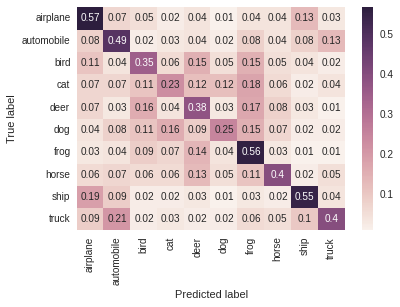

In [25]:
kn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train_simp, y_train)
helper.plot_confusion_matrix(kn_model,y_test,X_test_simp,file_name='../visuals/knn__color_cm.json')


Accuracy Score: 0.320266666667


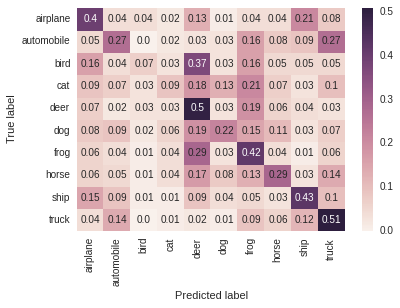

In [26]:
gnb_model=GaussianNB().fit(X_train_simp, y_train)
helper.plot_confusion_matrix(gnb_model,y_test,X_test_simp,file_name='../visuals/gnb__color_cm.json')

Accuracy Score: 0.372533333333


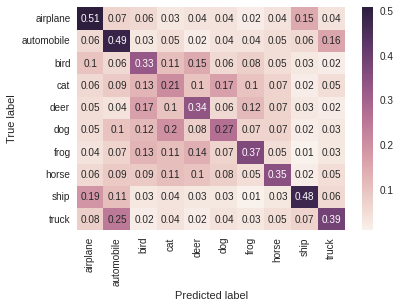

In [27]:
rf_model=RandomForestClassifier().fit(X_train_simp, y_train)
helper.plot_confusion_matrix(rf_model,y_test,X_test_simp,file_name='../visuals/rf__color_cm.json')

Accuracy Score: 0.4508


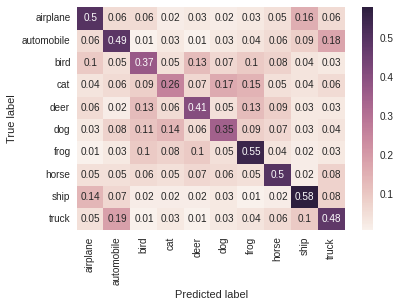

In [28]:
lr_model=LogisticRegression().fit(X_train_simp, y_train)
helper.plot_confusion_matrix(lr_model,y_test,X_test_simp,file_name='../visuals/lr__color_cm.json')